In [1]:
%load_ext autoreload
%autoreload 2

import os 
os.chdir("..")

from numerics.utilities.misc import * 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from numerics.integration.matrices import *
from numerics.machine_learning.models import * 

In [18]:
params, exp_path = def_params()
total_time = 100.
dt = 1e-4
states_si, dys_si = load(itraj=1, exp_path=exp_path, total_time=total_time, dt=dt, ext_signal=1)
#tfsignals = tf.convert_to_tensor(dys_si.astype(np.float32)[tf.newaxis])
times = get_time(total_time,dt).astype(np.float32)
dd = tf.unstack(dys_si.astype(np.float32),axis=1)

tfsignals = tf.stack([times[:-1],dd[0], dd[1]])
tfsignals = tf.transpose(tfsignals)[tf.newaxis]

multipdt = int(1e3)
tfsignals = tfsignals[:,::multipdt,:]
#tfsignals = tfsignals[:,0:int(1e3),:]


A, D , E, B  = genoni_matrices(*params)
xicov, covss = genoni_xi_cov(A,D, E, B ,params, stat=True)

initial_parameters = np.array([9.5, 2*np.pi/10]).astype(np.float32)
true_parameters = np.array([10., 2*np.pi/10]).astype(np.float32)

In [35]:
BS = len(tfsignals[0])
model = Model(params=params, dt=multipdt*dt, initial_parameters=initial_parameters, true_parameters=true_parameters, cov_in=covss, batch_size=(BS,None,3))
model.recurrent_layer.build(tf.TensorShape([1,None,3]))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

In [23]:
preds = model(tfsignals)[0][:,0]

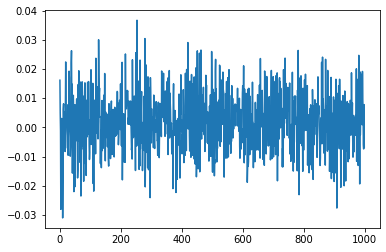

In [27]:
plt.plot(tfsignals[0][:,1])

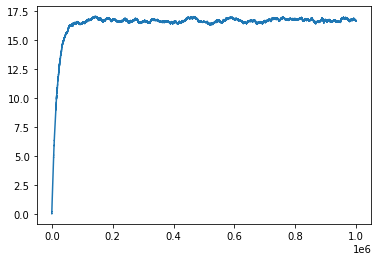

In [31]:
plt.plot(states_si[:,0])

In [36]:
history = model.fit(x=tfsignals, y=tfsignals, epochs=1000, batch_size=BS, shuffle=False,)

Epoch 1/1000
1/1 [==============================] - 0s 448ms/step - LOSS: 10839.9580 - PARAMS: 5.0637 - GRADS: 1142.1539
Epoch 2/1000
1/1 [==============================] - 0s 57ms/step - LOSS: 11257.5518 - PARAMS: 5.0632 - GRADS: 1156.5651
Epoch 3/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 11255.1963 - PARAMS: 5.0627 - GRADS: 1156.4445
Epoch 4/1000
1/1 [==============================] - 0s 67ms/step - LOSS: 11252.7998 - PARAMS: 5.0622 - GRADS: 1156.3209
Epoch 5/1000
1/1 [==============================] - 0s 62ms/step - LOSS: 11250.4463 - PARAMS: 5.0617 - GRADS: 1156.1996
Epoch 6/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 11248.0508 - PARAMS: 5.0612 - GRADS: 1156.0768
Epoch 7/1000
1/1 [==============================] - 0s 57ms/step - LOSS: 11245.6973 - PARAMS: 5.0607 - GRADS: 1155.9553
Epoch 8/1000
1/1 [==============================] - 0s 67ms/step - LOSS: 11243.3008 - PARAMS: 5.0602 - GRADS: 1155.8329
Epoch 9/1000
1/1 [=====================

1/1 [==============================] - 0s 58ms/step - LOSS: 11101.6152 - PARAMS: 5.0302 - GRADS: 1148.5272
Epoch 69/1000
1/1 [==============================] - 0s 57ms/step - LOSS: 11099.2773 - PARAMS: 5.0297 - GRADS: 1148.4064
Epoch 70/1000
1/1 [==============================] - 0s 67ms/step - LOSS: 11096.9414 - PARAMS: 5.0292 - GRADS: 1148.2853
Epoch 71/1000
1/1 [==============================] - 0s 57ms/step - LOSS: 11094.5605 - PARAMS: 5.0287 - GRADS: 1148.1621
Epoch 72/1000
1/1 [==============================] - 0s 67ms/step - LOSS: 11092.2227 - PARAMS: 5.0282 - GRADS: 1148.0411
Epoch 73/1000
1/1 [==============================] - 0s 62ms/step - LOSS: 11089.8887 - PARAMS: 5.0277 - GRADS: 1147.9202
Epoch 74/1000
1/1 [==============================] - 0s 57ms/step - LOSS: 11087.5088 - PARAMS: 5.0272 - GRADS: 1147.7975
Epoch 75/1000
1/1 [==============================] - 0s 68ms/step - LOSS: 11085.1719 - PARAMS: 5.0267 - GRADS: 1147.6761
Epoch 76/1000
1/1 [===========================

1/1 [==============================] - 0s 68ms/step - LOSS: 10944.9795 - PARAMS: 4.9968 - GRADS: 1140.3949
Epoch 136/1000
1/1 [==============================] - 0s 57ms/step - LOSS: 10942.6592 - PARAMS: 4.9963 - GRADS: 1140.2743
Epoch 137/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 10940.3398 - PARAMS: 4.9958 - GRADS: 1140.1536
Epoch 138/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 10938.0205 - PARAMS: 4.9953 - GRADS: 1140.0327
Epoch 139/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 10935.6787 - PARAMS: 4.9948 - GRADS: 1139.9111
Epoch 140/1000
1/1 [==============================] - 0s 57ms/step - LOSS: 10933.3379 - PARAMS: 4.9943 - GRADS: 1139.7885
Epoch 141/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 10931.0176 - PARAMS: 4.9938 - GRADS: 1139.6675
Epoch 142/1000
1/1 [==============================] - 0s 57ms/step - LOSS: 10928.6992 - PARAMS: 4.9933 - GRADS: 1139.5469
Epoch 143/1000
1/1 [===================

1/1 [==============================] - 0s 61ms/step - LOSS: 10789.9902 - PARAMS: 4.9636 - GRADS: 1132.2919
Epoch 203/1000
1/1 [==============================] - 0s 59ms/step - LOSS: 10787.6865 - PARAMS: 4.9631 - GRADS: 1132.1708
Epoch 204/1000
1/1 [==============================] - 0s 62ms/step - LOSS: 10785.3828 - PARAMS: 4.9626 - GRADS: 1132.0498
Epoch 205/1000
1/1 [==============================] - 0s 57ms/step - LOSS: 10783.0801 - PARAMS: 4.9621 - GRADS: 1131.9292
Epoch 206/1000
1/1 [==============================] - 0s 57ms/step - LOSS: 10780.7773 - PARAMS: 4.9616 - GRADS: 1131.8083
Epoch 207/1000
1/1 [==============================] - 0s 59ms/step - LOSS: 10778.4746 - PARAMS: 4.9611 - GRADS: 1131.6879
Epoch 208/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 10776.1719 - PARAMS: 4.9606 - GRADS: 1131.5665
Epoch 209/1000
1/1 [==============================] - 0s 68ms/step - LOSS: 10773.8701 - PARAMS: 4.9601 - GRADS: 1131.4458
Epoch 210/1000
1/1 [===================

1/1 [==============================] - 0s 57ms/step - LOSS: 10636.5898 - PARAMS: 4.9304 - GRADS: 1124.2137
Epoch 270/1000
1/1 [==============================] - 0s 56ms/step - LOSS: 10634.3457 - PARAMS: 4.9300 - GRADS: 1124.0953
Epoch 271/1000
1/1 [==============================] - 0s 68ms/step - LOSS: 10632.0596 - PARAMS: 4.9295 - GRADS: 1123.9739
Epoch 272/1000
1/1 [==============================] - 0s 56ms/step - LOSS: 10629.7725 - PARAMS: 4.9290 - GRADS: 1123.8533
Epoch 273/1000
1/1 [==============================] - 0s 59ms/step - LOSS: 10627.4863 - PARAMS: 4.9285 - GRADS: 1123.7322
Epoch 274/1000
1/1 [==============================] - 0s 66ms/step - LOSS: 10625.2432 - PARAMS: 4.9280 - GRADS: 1123.6139
Epoch 275/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 10622.9580 - PARAMS: 4.9275 - GRADS: 1123.4929
Epoch 276/1000
1/1 [==============================] - 0s 66ms/step - LOSS: 10620.6729 - PARAMS: 4.9270 - GRADS: 1123.3728
Epoch 277/1000
1/1 [===================

1/1 [==============================] - 0s 59ms/step - LOSS: 10484.8535 - PARAMS: 4.8974 - GRADS: 1116.1667
Epoch 337/1000
1/1 [==============================] - 0s 57ms/step - LOSS: 10482.5840 - PARAMS: 4.8969 - GRADS: 1116.0454
Epoch 338/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 10480.3564 - PARAMS: 4.8964 - GRADS: 1115.9271
Epoch 339/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 10478.0879 - PARAMS: 4.8959 - GRADS: 1115.8059
Epoch 340/1000
1/1 [==============================] - 0s 57ms/step - LOSS: 10475.8164 - PARAMS: 4.8955 - GRADS: 1115.6849
Epoch 341/1000
1/1 [==============================] - 0s 56ms/step - LOSS: 10473.5898 - PARAMS: 4.8950 - GRADS: 1115.5664
Epoch 342/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 10471.3223 - PARAMS: 4.8945 - GRADS: 1115.4458
Epoch 343/1000
1/1 [==============================] - 0s 66ms/step - LOSS: 10469.0947 - PARAMS: 4.8940 - GRADS: 1115.3270
Epoch 344/1000
1/1 [===================

1/1 [==============================] - 0s 58ms/step - LOSS: 10334.6445 - PARAMS: 4.8645 - GRADS: 1108.1416
Epoch 404/1000
1/1 [==============================] - 0s 67ms/step - LOSS: 10332.4326 - PARAMS: 4.8640 - GRADS: 1108.0229
Epoch 405/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 10330.1787 - PARAMS: 4.8635 - GRADS: 1107.9021
Epoch 406/1000
1/1 [==============================] - 0s 56ms/step - LOSS: 10327.9668 - PARAMS: 4.8630 - GRADS: 1107.7834
Epoch 407/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 10325.7363 - PARAMS: 4.8625 - GRADS: 1107.6638
Epoch 408/1000
1/1 [==============================] - 0s 57ms/step - LOSS: 10323.5039 - PARAMS: 4.8621 - GRADS: 1107.5443
Epoch 409/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 10321.2939 - PARAMS: 4.8616 - GRADS: 1107.4257
Epoch 410/1000
1/1 [==============================] - 0s 61ms/step - LOSS: 10319.0420 - PARAMS: 4.8611 - GRADS: 1107.3051
Epoch 411/1000
1/1 [===================

1/1 [==============================] - 0s 58ms/step - LOSS: 10186.0322 - PARAMS: 4.8317 - GRADS: 1100.1453
Epoch 471/1000
1/1 [==============================] - 0s 57ms/step - LOSS: 10183.8379 - PARAMS: 4.8312 - GRADS: 1100.0267
Epoch 472/1000
1/1 [==============================] - 0s 68ms/step - LOSS: 10181.6006 - PARAMS: 4.8307 - GRADS: 1099.9061
Epoch 473/1000
1/1 [==============================] - 0s 65ms/step - LOSS: 10179.4053 - PARAMS: 4.8302 - GRADS: 1099.7877
Epoch 474/1000
1/1 [==============================] - 0s 66ms/step - LOSS: 10177.2109 - PARAMS: 4.8297 - GRADS: 1099.6688
Epoch 475/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 10175.0166 - PARAMS: 4.8293 - GRADS: 1099.5502
Epoch 476/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 10172.7812 - PARAMS: 4.8288 - GRADS: 1099.4298
Epoch 477/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 10170.5859 - PARAMS: 4.8283 - GRADS: 1099.3110
Epoch 478/1000
1/1 [===================

1/1 [==============================] - 0s 62ms/step - LOSS: 10038.9258 - PARAMS: 4.7990 - GRADS: 1092.1725
Epoch 538/1000
1/1 [==============================] - 0s 59ms/step - LOSS: 10036.7461 - PARAMS: 4.7985 - GRADS: 1092.0538
Epoch 539/1000
1/1 [==============================] - 0s 56ms/step - LOSS: 10034.5674 - PARAMS: 4.7980 - GRADS: 1091.9353
Epoch 540/1000
1/1 [==============================] - 0s 56ms/step - LOSS: 10032.3887 - PARAMS: 4.7975 - GRADS: 1091.8169
Epoch 541/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 10030.2109 - PARAMS: 4.7970 - GRADS: 1091.6982
Epoch 542/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 10028.0322 - PARAMS: 4.7966 - GRADS: 1091.5797
Epoch 543/1000
1/1 [==============================] - 0s 67ms/step - LOSS: 10025.8535 - PARAMS: 4.7961 - GRADS: 1091.4611
Epoch 544/1000
1/1 [==============================] - 0s 72ms/step - LOSS: 10023.6777 - PARAMS: 4.7956 - GRADS: 1091.3422
Epoch 545/1000
1/1 [===================

1/1 [==============================] - 0s 56ms/step - LOSS: 9893.3555 - PARAMS: 4.7664 - GRADS: 1084.2242
Epoch 605/1000
1/1 [==============================] - 0s 57ms/step - LOSS: 9891.2129 - PARAMS: 4.7659 - GRADS: 1084.1068
Epoch 606/1000
1/1 [==============================] - 0s 57ms/step - LOSS: 9889.0713 - PARAMS: 4.7654 - GRADS: 1083.9897
Epoch 607/1000
1/1 [==============================] - 0s 56ms/step - LOSS: 9886.9082 - PARAMS: 4.7649 - GRADS: 1083.8711
Epoch 608/1000
1/1 [==============================] - 0s 62ms/step - LOSS: 9884.7461 - PARAMS: 4.7644 - GRADS: 1083.7527
Epoch 609/1000
1/1 [==============================] - 0s 67ms/step - LOSS: 9882.5840 - PARAMS: 4.7640 - GRADS: 1083.6340
Epoch 610/1000
1/1 [==============================] - 0s 59ms/step - LOSS: 9880.4219 - PARAMS: 4.7635 - GRADS: 1083.5153
Epoch 611/1000
1/1 [==============================] - 0s 56ms/step - LOSS: 9878.2598 - PARAMS: 4.7630 - GRADS: 1083.3967
Epoch 612/1000
1/1 [===========================

1/1 [==============================] - 0s 57ms/step - LOSS: 9749.3115 - PARAMS: 4.7339 - GRADS: 1076.3020
Epoch 672/1000
1/1 [==============================] - 0s 68ms/step - LOSS: 9747.1641 - PARAMS: 4.7334 - GRADS: 1076.1836
Epoch 673/1000
1/1 [==============================] - 0s 56ms/step - LOSS: 9745.0176 - PARAMS: 4.7329 - GRADS: 1076.0648
Epoch 674/1000
1/1 [==============================] - 0s 66ms/step - LOSS: 9742.9111 - PARAMS: 4.7324 - GRADS: 1075.9481
Epoch 675/1000
1/1 [==============================] - 0s 56ms/step - LOSS: 9740.7656 - PARAMS: 4.7320 - GRADS: 1075.8296
Epoch 676/1000
1/1 [==============================] - 0s 56ms/step - LOSS: 9738.6182 - PARAMS: 4.7315 - GRADS: 1075.7112
Epoch 677/1000
1/1 [==============================] - 0s 70ms/step - LOSS: 9736.4727 - PARAMS: 4.7310 - GRADS: 1075.5925
Epoch 678/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 9734.3262 - PARAMS: 4.7305 - GRADS: 1075.4739
Epoch 679/1000
1/1 [===========================

1/1 [==============================] - 0s 69ms/step - LOSS: 9606.7422 - PARAMS: 4.7015 - GRADS: 1068.4027
Epoch 739/1000
1/1 [==============================] - 0s 56ms/step - LOSS: 9604.6104 - PARAMS: 4.7010 - GRADS: 1068.2842
Epoch 740/1000
1/1 [==============================] - 0s 55ms/step - LOSS: 9602.5000 - PARAMS: 4.7005 - GRADS: 1068.1670
Epoch 741/1000
1/1 [==============================] - 0s 56ms/step - LOSS: 9600.3887 - PARAMS: 4.7000 - GRADS: 1068.0497
Epoch 742/1000
1/1 [==============================] - 0s 56ms/step - LOSS: 9598.2578 - PARAMS: 4.6996 - GRADS: 1067.9312
Epoch 743/1000
1/1 [==============================] - 0s 56ms/step - LOSS: 9596.1680 - PARAMS: 4.6991 - GRADS: 1067.8148
Epoch 744/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 9594.0381 - PARAMS: 4.6986 - GRADS: 1067.6964
Epoch 745/1000
1/1 [==============================] - 0s 56ms/step - LOSS: 9591.9082 - PARAMS: 4.6981 - GRADS: 1067.5779
Epoch 746/1000
1/1 [===========================

1/1 [==============================] - 0s 64ms/step - LOSS: 9465.6367 - PARAMS: 4.6692 - GRADS: 1060.5277
Epoch 806/1000
1/1 [==============================] - 0s 67ms/step - LOSS: 9463.5215 - PARAMS: 4.6687 - GRADS: 1060.4091
Epoch 807/1000
1/1 [==============================] - 0s 56ms/step - LOSS: 9461.4463 - PARAMS: 4.6682 - GRADS: 1060.2931
Epoch 808/1000
1/1 [==============================] - 0s 57ms/step - LOSS: 9459.3320 - PARAMS: 4.6677 - GRADS: 1060.1744
Epoch 809/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 9457.2578 - PARAMS: 4.6672 - GRADS: 1060.0575
Epoch 810/1000
1/1 [==============================] - 0s 67ms/step - LOSS: 9455.1426 - PARAMS: 4.6668 - GRADS: 1059.9393
Epoch 811/1000
1/1 [==============================] - 0s 69ms/step - LOSS: 9453.0684 - PARAMS: 4.6663 - GRADS: 1059.8229
Epoch 812/1000
1/1 [==============================] - 0s 56ms/step - LOSS: 9450.9551 - PARAMS: 4.6658 - GRADS: 1059.7042
Epoch 813/1000
1/1 [===========================

1/1 [==============================] - 0s 66ms/step - LOSS: 9325.9482 - PARAMS: 4.6370 - GRADS: 1052.6727
Epoch 873/1000
1/1 [==============================] - 0s 56ms/step - LOSS: 9323.8877 - PARAMS: 4.6365 - GRADS: 1052.5568
Epoch 874/1000
1/1 [==============================] - 0s 57ms/step - LOSS: 9321.8105 - PARAMS: 4.6360 - GRADS: 1052.4392
Epoch 875/1000
1/1 [==============================] - 0s 59ms/step - LOSS: 9319.7305 - PARAMS: 4.6355 - GRADS: 1052.3215
Epoch 876/1000
1/1 [==============================] - 0s 67ms/step - LOSS: 9317.6699 - PARAMS: 4.6350 - GRADS: 1052.2053
Epoch 877/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 9315.5723 - PARAMS: 4.6346 - GRADS: 1052.0867
Epoch 878/1000
1/1 [==============================] - 0s 59ms/step - LOSS: 9313.5137 - PARAMS: 4.6341 - GRADS: 1051.9708
Epoch 879/1000
1/1 [==============================] - 0s 68ms/step - LOSS: 9311.4551 - PARAMS: 4.6336 - GRADS: 1051.8549
Epoch 880/1000
1/1 [===========================

1/1 [==============================] - 0s 56ms/step - LOSS: 9187.7061 - PARAMS: 4.6048 - GRADS: 1044.8411
Epoch 940/1000
1/1 [==============================] - 0s 57ms/step - LOSS: 9185.6611 - PARAMS: 4.6043 - GRADS: 1044.7247
Epoch 941/1000
1/1 [==============================] - 0s 69ms/step - LOSS: 9183.6162 - PARAMS: 4.6039 - GRADS: 1044.6088
Epoch 942/1000
1/1 [==============================] - 0s 57ms/step - LOSS: 9181.5732 - PARAMS: 4.6034 - GRADS: 1044.4918
Epoch 943/1000
1/1 [==============================] - 0s 59ms/step - LOSS: 9179.5303 - PARAMS: 4.6029 - GRADS: 1044.3756
Epoch 944/1000
1/1 [==============================] - 0s 56ms/step - LOSS: 9177.4473 - PARAMS: 4.6024 - GRADS: 1044.2572
Epoch 945/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 9175.4043 - PARAMS: 4.6020 - GRADS: 1044.1415
Epoch 946/1000
1/1 [==============================] - 0s 55ms/step - LOSS: 9173.3613 - PARAMS: 4.6015 - GRADS: 1044.0251
Epoch 947/1000
1/1 [===========================

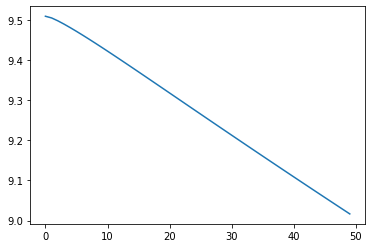

In [40]:
plt.plot(np.squeeze(history.history["PARAMS"])[:,0])

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [37]:
tf.config.list_physical_devices('GPU')

[]